
# **PROYECTO IA2**

##FLORIFICADOR
###(CLASIFICADOR DE FLORES)

In [107]:
#@title 1. MONTAR EL DRIVE{ display-mode: "form" }
#@markdown 
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/pp')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/pp


In [108]:
#@title Cargar librerias y funciones { display-mode: "form" }
#@markdown Se recomienda correr el entorno de ejecución en GPU
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import sys
import random

In [109]:
#@title se carga el data-set   { display-mode: "form" }
#@markdown Obtenemos nuestro data set de Kaggle, el cual usaremos para etrenar nuestro clasificador de flores. 
os.environ['KAGGLE_CONFIG_DIR0']='/content/drive/MyDrive/IA2/proyecto'
%cd /content/drive/MyDrive/pp/Train_flowers/new
!kaggle datasets download -d bogdancretu/flower299
!mkdir Train_flowers
!mv archive.zip Train_flowers
%cd Train_flowers/
data = '/content/drive/MyDrive/pp/Train_flowers/new'

/content/drive/MyDrive/pp/Train_flowers/new
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
mkdir: cannot create directory ‘Train_flowers’: File exists
mv: cannot stat 'archive.zip': No such file or directory
/content/drive/MyDrive/pp/Train_flowers/new/Train_flowers


In [110]:
#@title se buscan archivos en el directorio y luego se imprime la lista de nombres y su longitud.
#@markdown
Name=[]
for file in os.listdir(data):
    Name+=[file]
    
print(Name)
print(len(Name))

['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', 'Train_flowers']
18


In [111]:
#@title crear un mapeo entre nombres de archivo y índices.
#@markdown se proporciona una función para mapear de vuelta de índices a nombres de archivo.
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [112]:

#@markdown se cargan las imagenes y se normaliza  sus valores de pixel y asignándoles etiquetas, y luego agregando cada imagen y su etiqueta a una lista "dataset". 
 
dataset=[]
count=0
for file in tqdm(os.listdir(data)):
    path=os.path.join(data,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(40,40))
        image=img_to_array(image)
        image=image/255.0
        dataset+=[[image,count]]
    count=count+1

100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


In [113]:
#@markdown número de imágenes y etiquetas en la lista "dataset".
n=len(dataset)
print("hay " , n ," imagenes con sus respectivas etiquetas")

hay  7134  imagenes con sus respectivas etiquetas


In [114]:
#@markdown se genera una lista de números enteros consecutivos y luego se baraja de manera aleatoria.
num=[]
for i in range(n):
    num+=[i]
random.shuffle(num)
print(num[0:5])

[4196, 348, 3200, 1661, 1465]


In [115]:
#@markdown se dividen los conjuntos de imágenes y etiquetas en dos conjuntos: un conjunto de entrenamiento y un conjunto de prueba y luego se prepara las etiquetas para su uso en un modelo de aprendizaje automático.
data,labels=zip(*dataset)
data=np.array(data)
labels=np.array(labels)

train=data[num[0:(n//10)*8]]
trainlabel=labels[num[0:(n//10)*8]]

test=data[num[(n//10)*8:]]
testlabel=labels[num[(n//10)*8:]]

trainlabel2=to_categorical(trainlabel)
x_train,x_test,y_train,y_test=train_test_split(train,trainlabel2,test_size=0.2,random_state=44)

In [116]:
#@markdown  imprime las dimensiones de cada uno de los arrays para verificar que estos tengan las dimensiones esperadas y que se hayan generado correctamente.
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4563, 40, 40, 3)
(1141, 40, 40, 3)
(4563, 17)
(1141, 17)


# **Transfer learning**

In [117]:
#@markdown se generan imágenes modificadas para el  entrenamiento para poder aumentar las posibilidades de que el modelo generalice bien los nuevos datos y evite overfitting.
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [118]:
#@markdown se carga el modelo pre-entrenado de la biblioteca TensorFlow (Keras) llamado ResNet152V2. Este modelo es una red neuronal de la arquitectura ResNet (Residual Network), que es una de las redes más populares y exitosas para el aprendizaje profundo de imágenes.
pretrained_model3 = tf.keras.applications.ResNet152V2(input_shape=(40,40,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [119]:
#@markdown se construye un nuevo modelo utilizando el modelo pre-entrenado pretrained_model3.
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(17, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [120]:
#@markdown se compila el modelo que se creó previamente.
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [121]:
#@markdown se entrena el modelo de aprendizaje profundo usando la arquitectura previamente entrenada (ResNet152V2).
his=model.fit(datagen.flow(x_train,y_train,batch_size=32),validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
143/143 [==============================] - 170s 1s/step - loss: 2.6693 - accuracy: 0.1804 - val_loss: 2.4770 - val_accuracy: 0.2375
Epoch 2/10
143/143 [==============================] - 138s 968ms/step - loss: 2.4418 - accuracy: 0.2468 - val_loss: 2.3989 - val_accuracy: 0.2515
Epoch 3/10
143/143 [==============================] - 152s 1s/step - loss: 2.3562 - accuracy: 0.2700 - val_loss: 2.3658 - val_accuracy: 0.2603
Epoch 4/10
143/143 [==============================] - 136s 954ms/step - loss: 2.3001 - accuracy: 0.2897 - val_loss: 2.3189 - val_accuracy: 0.2743
Epoch 5/10
143/143 [==============================] - 155s 1s/step - loss: 2.2729 - accuracy: 0.2974 - val_loss: 2.2755 - val_accuracy: 0.2813
Epoch 6/10
143/143 [==============================] - 153s 1s/step - loss: 2.2226 - accuracy: 0.2965 - val_loss: 2.2503 - val_accuracy: 0.2997
Epoch 7/10
143/143 [==============================] - 151s 1s/step - loss: 2.2106 - accuracy: 0.3046 - val_loss: 2.2579 - val_accuracy: 

In [122]:
#@markdown se realiza una evaluación del modelo previamente entrenado y compilado. La salida final es un reporte de clasificación que incluye las métricas precisión, recall y F1-score para cada clase.
y_pred=model.predict(x_test)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
print(classification_report(ground,pred))

36/36 [==============================] - 30s 709ms/step
              precision    recall  f1-score   support

           0       0.60      0.38      0.47        76
           1       0.25      0.22      0.23        59
           2       0.22      0.13      0.16        47
           3       0.32      0.20      0.25        50
           4       0.32      0.38      0.34        72
           5       0.31      0.57      0.41        79
           6       0.30      0.59      0.40        66
           7       0.24      0.29      0.26        70
           8       0.24      0.15      0.18        81
           9       0.23      0.55      0.32        60
          10       0.42      0.23      0.30        73
          11       0.32      0.45      0.37        67
          12       0.34      0.25      0.29        60
          13       0.32      0.26      0.29        50
          14       0.21      0.10      0.14        78
          15       0.39      0.18      0.25        78
          16       0.42  

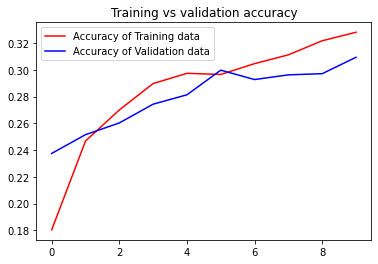

<Figure size 432x288 with 0 Axes>

In [123]:
#@markdown se grafica la precisión (accuracy) de entrenamiento y validación durante los epochs en una gráfica de línea.
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

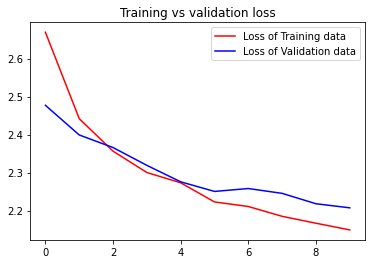

<Figure size 432x288 with 0 Axes>

In [124]:
#@markdown Se grafica la evolución de la pérdida (loss) durante el entrenamiento y la validación durante los epochs en una gráfica de línea.
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

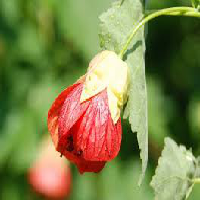

In [125]:
#@markdown Se cargar una imagen desde una ruta específica y se cambia su tamaño a 200x200 píxeles.
img0_path='/content/drive/MyDrive/pp/Train_flowers/new/Abutilon/02621a076a.jpg'
load_img(img0_path,target_size=(200,200))

In [126]:
#@markdown se redimensiona la imagen a 40x40 pixels. Luego, se convierte la imagen en un array y se normalizan los valores del pixel para que estén en el rango de 0 a 1 (dividiendo por 255). Finalmente, se agrega una dimensión adicional a la imagen, lo que la convierte en una matriz de tamaño (1, 40, 40, 3). 
image=load_img(img0_path,target_size=(40,40))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [127]:
#@markdown Se realiza una Clasificacion con una imagen específica
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
name=mapper(value)
print("Prediction is {}.".format(name))

1/1 [==============================] - 0s 163ms/step
Prediction is Abutilon.


In [128]:
#@markdown Se realiza una clasificacion sobre un conjunto de imágenes. Ademas, se itera a través de cada vector de probabilidades y se toma el índice con la probabilidad más alta, lo que representa la clase más probable para la imagen.
pred2=model.predict(test)
print(test.shape)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

45/45 [==============================] - 34s 738ms/step
(1430, 40, 40, 3)
(1430, 17)


In [129]:
#@markdown Se evalua la precisión del modelo en los datos de prueba. 
ANS=testlabel
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.3258741258741259


# **RED NEURONAL CNN**

In [152]:
#@markdown Se crea un modelo de red neuronal de tipo Convolucional (CNN) en TensorFlow (tf) con la API de Keras. 
model_CNN =  tf.keras.models.Sequential()
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(40, 40, 3)))
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dense(17, activation='softmax'))
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                      

In [153]:
#@markdown Se compila el modelo de red neuronal
opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9,beta_2=0.999)
model_CNN.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [154]:
#@markdown Se entrena el modelo de red neuronal en TensorFlow (tf) con la API de Keras.
history = model_CNN.fit(x_train,y_train, epochs=10, batch_size=32,validation_data=(x_test,y_test))

Epoch 1/10
143/143 [==============================] - 133s 883ms/step - loss: 2.4523 - accuracy: 0.2222 - val_loss: 2.1631 - val_accuracy: 0.3234
Epoch 2/10
143/143 [==============================] - 107s 746ms/step - loss: 1.9864 - accuracy: 0.3794 - val_loss: 1.9538 - val_accuracy: 0.3874
Epoch 3/10
143/143 [==============================] - 107s 748ms/step - loss: 1.6288 - accuracy: 0.5014 - val_loss: 1.8273 - val_accuracy: 0.4417
Epoch 4/10
143/143 [==============================] - 104s 730ms/step - loss: 1.1471 - accuracy: 0.6522 - val_loss: 1.6703 - val_accuracy: 0.5320
Epoch 5/10
143/143 [==============================] - 109s 765ms/step - loss: 0.6803 - accuracy: 0.7953 - val_loss: 1.6510 - val_accuracy: 0.5828
Epoch 6/10
143/143 [==============================] - 103s 717ms/step - loss: 0.3361 - accuracy: 0.8994 - val_loss: 1.9347 - val_accuracy: 0.6004
Epoch 7/10
143/143 [==============================] - 104s 726ms/step - loss: 0.1822 - accuracy: 0.9459 - val_loss: 2.5402 -

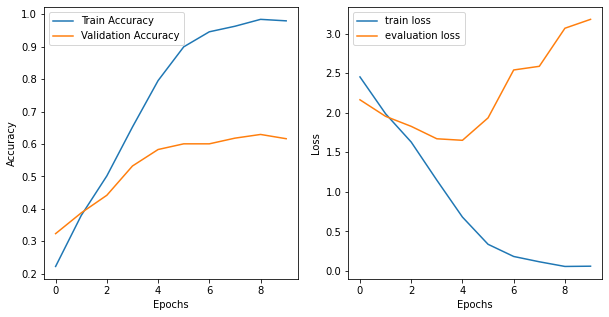

In [155]:
#@markdown Se crea una figura de dos subplots con la intención de visualizar la precisión y la pérdida durante el entrenamiento del modelo.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

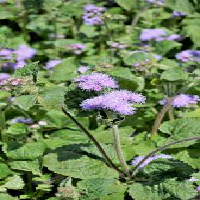

In [156]:
#@markdown Se carga una imagen desde una ruta específica y se cambia su tamaño a 200x200 píxeles.
img0_path='/content/drive/MyDrive/pp/Train_flowers/new/Ageratum/images (1).jpg'
load_img(img0_path,target_size=(200,200))

In [157]:
#@markdown se redimensiona la imagen a 40x40 pixels. Luego, se convierte la imagen en un array y se normalizan los valores del pixel para que estén en el rango de 0 a 1 (dividiendo por 255). Finalmente, se agrega una dimensión adicional a la imagen, lo que la convierte en una matriz de tamaño (1, 40, 40, 3). 
image=load_img(img0_path,target_size=(40,40))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [158]:
#@markdown Se realiza una Clasificacion con una imagen específica
prediction=model_CNN(prediction_image)
value=np.argmax(prediction)
name=mapper(value)
print("Prediction is {}.".format(name))

Prediction is Abutilon.


In [159]:
#@markdown Se realiza una clasificacion sobre un conjunto de imágenes. Ademas, se itera a través de cada vector de probabilidades y se toma el índice con la probabilidad más alta, lo que representa la clase más probable para la imagen.
pred2=model_CNN.predict(test)
print(test.shape)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

45/45 [==============================] - 7s 151ms/step
(1430, 40, 40, 3)
(1430, 17)


In [160]:
#@markdown Se evalua la precisión del modelo en los datos de prueba. 
ANS=testlabel
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.6412587412587413


#**transfer learning VGG19**

In [139]:
#@markdown se generan imágenes modificadas para el  entrenamiento para poder aumentar las posibilidades de que el modelo generalice bien los nuevos datos y evite overfitting.
datagen1 = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [140]:
#@markdown se carga el modelo pre-entrenado de la biblioteca TensorFlow (Keras) llamado VGG19.
pretrained_model4 = tf.keras.applications.VGG19(input_shape=(40,40,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model4.trainable = False

In [141]:
#@markdown se construye un nuevo modelo utilizando el modelo pre-entrenado pretrained_model3.
inputs3 = pretrained_model4.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model4.output)
outputs3 = tf.keras.layers.Dense(17, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [142]:
#@markdown se compila el modelo que se creó previamente.
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [143]:
#@markdown se entrena el modelo de aprendizaje profundo usando la arquitectura previamente entrenada (VGG19).
his=model.fit(datagen1.flow(x_train,y_train,batch_size=32),validation_data=(x_test,y_test),epochs=20)

Epoch 1/20
143/143 [==============================] - 158s 1s/step - loss: 2.6259 - accuracy: 0.1723 - val_loss: 2.4433 - val_accuracy: 0.2349
Epoch 2/20
143/143 [==============================] - 157s 1s/step - loss: 2.4013 - accuracy: 0.2512 - val_loss: 2.3214 - val_accuracy: 0.2840
Epoch 3/20
143/143 [==============================] - 142s 998ms/step - loss: 2.3108 - accuracy: 0.2801 - val_loss: 2.2480 - val_accuracy: 0.3015
Epoch 4/20
143/143 [==============================] - 158s 1s/step - loss: 2.2441 - accuracy: 0.2974 - val_loss: 2.2157 - val_accuracy: 0.2962
Epoch 5/20
143/143 [==============================] - 154s 1s/step - loss: 2.2056 - accuracy: 0.3044 - val_loss: 2.1731 - val_accuracy: 0.3339
Epoch 6/20
143/143 [==============================] - 155s 1s/step - loss: 2.1681 - accuracy: 0.3259 - val_loss: 2.1653 - val_accuracy: 0.3260
Epoch 7/20
143/143 [==============================] - 159s 1s/step - loss: 2.1718 - accuracy: 0.3246 - val_loss: 2.1217 - val_accuracy: 0.3

In [144]:
#@markdown se realiza una evaluación del modelo previamente entrenado y compilado. La salida final es un reporte de clasificación que incluye las métricas precisión, recall y F1-score para cada clase.
y_pred=model.predict(x_test)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
print(classification_report(ground,pred))

36/36 [==============================] - 28s 789ms/step
              precision    recall  f1-score   support

           0       0.53      0.54      0.53        76
           1       0.25      0.29      0.27        59
           2       0.29      0.38      0.33        47
           3       0.37      0.40      0.38        50
           4       0.41      0.44      0.42        72
           5       0.51      0.54      0.52        79
           6       0.51      0.67      0.58        66
           7       0.32      0.43      0.37        70
           8       0.31      0.33      0.32        81
           9       0.25      0.42      0.31        60
          10       0.49      0.45      0.47        73
          11       0.43      0.57      0.49        67
          12       0.53      0.28      0.37        60
          13       0.34      0.38      0.36        50
          14       0.29      0.09      0.14        78
          15       0.50      0.19      0.28        78
          16       0.40  

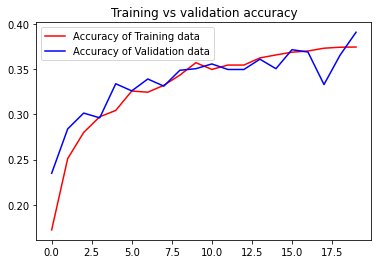

<Figure size 432x288 with 0 Axes>

In [145]:
#@markdown se grafica la precisión (accuracy) de entrenamiento y validación durante los epochs en una gráfica de línea.
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

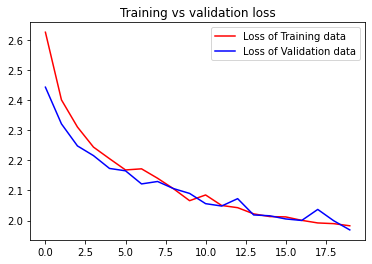

<Figure size 432x288 with 0 Axes>

In [146]:
#@markdown Se grafica la evolución de la pérdida (loss) durante el entrenamiento y la validación durante los epochs en una gráfica de línea.
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

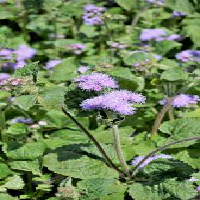

In [147]:
#@markdown Se carga una imagen desde una ruta específica y se cambia su tamaño a 200x200 píxeles.
img0_path='/content/drive/MyDrive/pp/Train_flowers/new/Ageratum/images (1).jpg'
load_img(img0_path,target_size=(200,200))

In [148]:
#@markdown se redimensiona la imagen a 40x40 pixels. Luego, se convierte la imagen en un array y se normalizan los valores del pixel para que estén en el rango de 0 a 1 (dividiendo por 255). Finalmente, se agrega una dimensión adicional a la imagen, lo que la convierte en una matriz de tamaño (1, 40, 40, 3). 
image=load_img(img0_path,target_size=(40,40))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [149]:
#@markdown Se realiza una Clasificacion con una imagen específica
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
name=mapper(value)
print("Prediction is {}.".format(name))

1/1 [==============================] - 0s 64ms/step
Prediction is AfricanDaisy.


In [150]:
#@markdown Se realiza una clasificacion sobre un conjunto de imágenes. Ademas, se itera a través de cada vector de probabilidades y se toma el índice con la probabilidad más alta, lo que representa la clase más probable para la imagen.
pred2=model.predict(test)
print(test.shape)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

45/45 [==============================] - 34s 765ms/step
(1430, 40, 40, 3)
(1430, 17)


In [151]:
#@markdown Se evalua la precisión del modelo en los datos de prueba. 
ANS=testlabel
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.4090909090909091


#**CONCLUSIONES**

1.El uso de redes neuronales convolucionales (CNN) es una técnica efectiva para el procesamiento de imágenes. Las CNN utilizan filtros para extraer características de las imágenes, lo que permite una mejor detección de patrones en los datos.

2.La transferencia de aprendizaje con arquitecturas pre-entrenadas como ResNet y VGG19 es una estrategia útil para entrenar modelos de redes neuronales de manera eficiente y con resultados precisos. La utilización de una red pre-entrenada permite reducir el tiempo y recursos necesarios para entrenar un modelo desde cero.

3.Al combinar CNN y transferencia de aprendizaje con ResNet y VGG19, se puede lograr una mayor precisión en la clasificación de imágenes. La combinación de estas técnicas permite aprovechar el poder de la extracción de características de las redes pre-entrenadas y personalizar el modelo para el conjunto de datos específico.

4.Es importante tener en cuenta que la elección de la arquitectura y la técnica de transferencia de aprendizaje dependerá del conjunto de datos y del objetivo del proyecto. Cada arquitectura y técnica tiene sus propias ventajas y limitaciones.

5.La red neuronal de tipo Convolucional (CNN) en TensorFlow (tf) con la API de Keras es el modelo de red neuronal con mayor accuracy por ello posee mayor precision al momento de clasificar imagenes con respecto al data set empleado.